# Approach 2  - Using Features - Model 1 - LSTM  and Model 2 - MLP 

In [ ]:
### Importing all the neceaasry package 

In [ ]:
import csv
import numpy as np
import random
import glob
import os.path
import sys
import operator
import threading
from processor import process_image
from keras.utils import to_categorical

In [2]:
sequence_path = os.path.join('data', 'sequences')

In [3]:
seq_length = 40
max_frames = 300  # max number of frames a video can have for us to use it

# for lstm and mlp 

data_type = 'features'
features_length=2048
input_shape = (seq_length, features_length)



In [4]:
##################################              get data 

with open(os.path.join('data', 'data_file.csv'), 'r') as fin:
    reader = csv.reader(fin)
    data = list(reader)


#################################                Get Class     
classes = []
for item in data:
    if item[1] not in classes:
        classes.append(item[1])

# Sort them.
classes = sorted(classes)

#############################                     clean data 

data_clean = []
for item in data:
    if int(item[3]) >= seq_length and int(item[3]) <= max_frames and item[1] in classes:
        data_clean.append(item)    
    



data=  data_clean
    

In [7]:
def split_train_test():

    train = []
    test = []
    finaltest=[]
    for item in data:
        if item[0] == 'train':
            train.append(item)
        if item[0] == 'finaltest':
            finaltest.append(item)
        if item[0] == 'test':
            test.append(item)
    return train, test, finaltest

In [8]:
# Function to make y variable one hot encoding 
def get_class_one_hot(class_str):

    # Encode it first.
    label_encoded = classes.index(class_str)

    # Now one-hot it.
    label_hot = to_categorical(label_encoded, len(classes))

    assert len(label_hot) == len(classes)
#     print("one hot encodervalue ")
#     print(label_hot)

    return label_hot

In [9]:
# function to build the sequence from image  
def build_image_sequence(frames):
    return [process_image(x, image_shape) for x in frames]




In [10]:

def get_extracted_sequence( data_type, sample):
    filename = sample[2]
    path = os.path.join(sequence_path, filename + '-' + str(seq_length) + '-' + data_type + '.npy')
    if os.path.isfile(path):
        return np.load(path)
    else:
        return None




In [11]:
def get_frames_for_sample(sample):

    path = os.path.join('data', sample[0], sample[1])
    filename = sample[2]
    images = sorted(glob.glob(os.path.join(path, filename + '*jpg')))
    return images


In [12]:

def get_filename_from_image(filename):
    parts = filename.split(os.path.sep)
    return parts[-1].replace('.jpg', '')

In [13]:
# FUNCTION TO resca; the image
def rescale_list(input_list, size):

    assert len(input_list) >= size

    # Get the number to skip between iterations.
    skip = len(input_list) // size

    # Build our new output.
    output = [input_list[i] for i in range(0, len(input_list), skip)]

    # Cut off the last one if needed.
    return output[:size]




In [14]:
from tqdm import tqdm
pbar = tqdm(total=len(data))

  0%|                                                                                        | 0/12014 [00:00<?, ?it/s]

In [15]:
def get_all_sequences_in_memory(train_test_finaltest, data_type):

    # Get the right dataset.
    train, test, finaltest = split_train_test()

    if train_test_finaltest == 'test':
        data= test
    if train_test_finaltest == 'train':
        data = train
    if train_test_finaltest == 'finaltest':
        data= finaltest




    print("Loading %d samples into memory for %sing." % (len(data), train_test_finaltest))
#     print(data)

    X, y = [], []
    for row in data:
#         print("****************************************************")

#         print(row)
        
        if data_type == 'images':
            print("////////////eeeeeeeeeeeeeeeeeeeeeeeeeeee///////////////")
            print(row)
            frames = get_frames_for_sample(row)
            frames = rescale_list(frames, seq_length)
            print(frames)

            # Build the image sequence
            sequence = build_image_sequence(frames)

        else:
            sequence = get_extracted_sequence(data_type, row)

            if sequence is None:
                print("Can't find sequence. Did you generate them?")
                raise

        X.append(sequence)
#         y.append((row[1]))
        y.append(get_class_one_hot(row[1]))

#         print("*********????????????? printying xarry value of getall sequency in memory ///////")
#         print(np.array(X))
#         print("*********????????????? printying yarry value of getall sequency in memory ///////")
#         print(np.array(y))

    return np.array(X), np.array(y)



In [16]:
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model, load_model
from keras.layers import Input
import numpy as np
from tqdm import tqdm

In [17]:

# Get model with pretrained weights.
base_model = InceptionV3(weights='imagenet', include_top=True)



In [18]:
# We'll extract features at the final pool layer.
inception_model = Model(inputs=base_model.input,outputs=base_model.get_layer('avg_pool').output)

In [19]:

for video in data:

    # Get the path to the sequence for this video.
    path = os.path.join('data', 'sequences', video[2] + '-' + str(seq_length) + '-features')  # numpy will auto-append .npy

    # Check if we already have it.
    if os.path.isfile(path + '.npy'):
        pbar.update(1)
        continue

    # Get the frames for this video.
    frames = get_frames_for_sample(video)

    # Now downsample to just the ones we need.
    frames = rescale_list(frames, seq_length)


    # Now loop through and extract features to build the sequence.
    sequence = []
    for image_path in frames:
        print(image_path)
        img = image.load_img(image_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        # Get the prediction.
        features = inception_model.predict(x)

        features = features[0]
        
        sequence.append(features)

    # Save the sequence.
    np.save(path, sequence)

    pbar.update(1)

pbar.close()


100%|███████████████████████████████████████████████████████████████████████████| 12014/12014 [00:23<00:00, 503.81it/s]


In [20]:
from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D,
    MaxPooling2D)
from collections import deque
import sys

from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
import time


# Build LSTM model 

In [21]:
nb_classes= len(classes)
features_length=2048
input_shape = (seq_length, features_length)

In [21]:
nb_classes= len(classes)
features_length=2048
input_shape = (seq_length, features_length)

model_lstm = Sequential()
model_lstm.add(LSTM(2048, return_sequences=False,input_shape=input_shape, dropout=0.5))
model_lstm.add(Dense(512, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(256, activation='relu'))


model_lstm.add(Dense(nb_classes, activation='softmax'))

In [24]:
# compiling the model 
metrics = ['accuracy']
if nb_classes >= 10:
    metrics.append('top_k_categorical_accuracy')
    
optimizer = Adam(lr=1e-5, decay=1e-6)
model_lstm.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)

print(model_lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2048)              33562624  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 101)               25957     
Total params: 34,768,997
Trainable params: 34,768,997
Non-trainable params: 0
_________________________________________________________________
None


In [23]:


checkpointer1 = ModelCheckpoint(
    filepath=os.path.join('data', 'checkpoints', 'lstm' + '-' + data_type + '.{epoch:03d}-{val_loss:.3f}.hdf5'),verbose=1, save_best_only=True)

# Helper: TensorBoard
tb_lstm = TensorBoard(log_dir=os.path.join('data', 'logs', 'lstm'))

# Helper: Stop when we stop learning.
early_stopper_lstm = EarlyStopping(patience=5)

# Helper: Save results.
timestamp_lstm = time.time()
csv_logger_lstm = CSVLogger(os.path.join('data', 'logs', 'lstm' + '-' + 'training-' + str(timestamp_lstm) + '.log'))

In [22]:
X_lstm,Y_lstm =get_all_sequences_in_memory('train', data_type)

Loading 8596 samples into memory for training.


In [28]:
X_lstm_val,Y_lstm_val =get_all_sequences_in_memory('test', data_type)

Loading 1712 samples into memory for testing.


In [29]:
X_lstm_test,Y_lstm_test =get_all_sequences_in_memory('finaltest', data_type)

Loading 1706 samples into memory for finaltesting.


In [27]:
# fitting the model 
history = model_lstm.fit( X_lstm,Y_lstm, 
    batch_size=32,
    validation_data=(X_lstm_val,Y_lstm_val ),
    verbose=1,
    callbacks=[tb_lstm, early_stopper_lstm, csv_logger_lstm],
    epochs=200)

Train on 8596 samples, validate on 1712 samples
Epoch 1/200
3424/8596 [==========>...................] - ETA: 6:16 - loss: 4.6079 - acc: 0.0312 - top_k_categorical_accuracy: 0.09 - ETA: 4:21 - loss: 4.6441 - acc: 0.0156 - top_k_categorical_accuracy: 0.06 - ETA: 3:42 - loss: 4.6526 - acc: 0.0104 - top_k_categorical_accuracy: 0.06 - ETA: 3:22 - loss: 4.6531 - acc: 0.0078 - top_k_categorical_accuracy: 0.04 - ETA: 3:11 - loss: 4.6654 - acc: 0.0063 - top_k_categorical_accuracy: 0.03 - ETA: 3:02 - loss: 4.6745 - acc: 0.0052 - top_k_categorical_accuracy: 0.03 - ETA: 2:56 - loss: 4.6730 - acc: 0.0045 - top_k_categorical_accuracy: 0.03 - ETA: 2:52 - loss: 4.6757 - acc: 0.0039 - top_k_categorical_accuracy: 0.03 - ETA: 2:48 - loss: 4.6820 - acc: 0.0035 - top_k_categorical_accuracy: 0.03 - ETA: 2:45 - loss: 4.6787 - acc: 0.0063 - top_k_categorical_accuracy: 0.04 - ETA: 2:42 - loss: 4.6796 - acc: 0.0057 - top_k_categorical_accuracy: 0.03 - ETA: 2:40 - loss: 4.6751 - acc: 0.0078 - top_k_categorical_

3456/8596 [===========>..................] - ETA: 2:29 - loss: 4.4355 - acc: 0.0312 - top_k_categorical_accuracy: 0.18 - ETA: 2:29 - loss: 4.4875 - acc: 0.0469 - top_k_categorical_accuracy: 0.17 - ETA: 2:29 - loss: 4.4785 - acc: 0.0417 - top_k_categorical_accuracy: 0.17 - ETA: 2:29 - loss: 4.4884 - acc: 0.0391 - top_k_categorical_accuracy: 0.15 - ETA: 2:28 - loss: 4.5124 - acc: 0.0312 - top_k_categorical_accuracy: 0.14 - ETA: 2:28 - loss: 4.5165 - acc: 0.0365 - top_k_categorical_accuracy: 0.13 - ETA: 2:27 - loss: 4.5127 - acc: 0.0446 - top_k_categorical_accuracy: 0.14 - ETA: 2:27 - loss: 4.5182 - acc: 0.0430 - top_k_categorical_accuracy: 0.13 - ETA: 2:26 - loss: 4.5194 - acc: 0.0417 - top_k_categorical_accuracy: 0.12 - ETA: 2:26 - loss: 4.5264 - acc: 0.0375 - top_k_categorical_accuracy: 0.12 - ETA: 2:25 - loss: 4.5305 - acc: 0.0341 - top_k_categorical_accuracy: 0.11 - ETA: 2:25 - loss: 4.5263 - acc: 0.0339 - top_k_categorical_accuracy: 0.11 - ETA: 2:24 - loss: 4.5241 - acc: 0.0337 - to

8596/8596 [==============================] - ETA: 29s - loss: 4.4641 - acc: 0.0465 - top_k_categorical_accuracy: 0.153 - ETA: 28s - loss: 4.4639 - acc: 0.0464 - top_k_categorical_accuracy: 0.153 - ETA: 28s - loss: 4.4636 - acc: 0.0464 - top_k_categorical_accuracy: 0.153 - ETA: 27s - loss: 4.4631 - acc: 0.0463 - top_k_categorical_accuracy: 0.153 - ETA: 27s - loss: 4.4627 - acc: 0.0464 - top_k_categorical_accuracy: 0.153 - ETA: 26s - loss: 4.4625 - acc: 0.0469 - top_k_categorical_accuracy: 0.154 - ETA: 26s - loss: 4.4619 - acc: 0.0469 - top_k_categorical_accuracy: 0.155 - ETA: 25s - loss: 4.4619 - acc: 0.0472 - top_k_categorical_accuracy: 0.155 - ETA: 24s - loss: 4.4616 - acc: 0.0472 - top_k_categorical_accuracy: 0.155 - ETA: 24s - loss: 4.4605 - acc: 0.0477 - top_k_categorical_accuracy: 0.155 - ETA: 23s - loss: 4.4609 - acc: 0.0478 - top_k_categorical_accuracy: 0.155 - ETA: 23s - loss: 4.4602 - acc: 0.0480 - top_k_categorical_accuracy: 0.156 - ETA: 22s - loss: 4.4598 - acc: 0.0480 - top

3456/8596 [===========>..................] - ETA: 2:28 - loss: 3.9301 - acc: 0.1250 - top_k_categorical_accuracy: 0.28 - ETA: 2:28 - loss: 3.9652 - acc: 0.1406 - top_k_categorical_accuracy: 0.34 - ETA: 2:27 - loss: 3.9818 - acc: 0.1354 - top_k_categorical_accuracy: 0.36 - ETA: 2:27 - loss: 3.9995 - acc: 0.1484 - top_k_categorical_accuracy: 0.35 - ETA: 2:26 - loss: 3.9863 - acc: 0.1375 - top_k_categorical_accuracy: 0.35 - ETA: 2:26 - loss: 4.0025 - acc: 0.1250 - top_k_categorical_accuracy: 0.35 - ETA: 2:25 - loss: 4.0008 - acc: 0.1250 - top_k_categorical_accuracy: 0.35 - ETA: 2:24 - loss: 3.9927 - acc: 0.1367 - top_k_categorical_accuracy: 0.35 - ETA: 2:24 - loss: 3.9915 - acc: 0.1493 - top_k_categorical_accuracy: 0.36 - ETA: 2:23 - loss: 3.9719 - acc: 0.1500 - top_k_categorical_accuracy: 0.36 - ETA: 2:23 - loss: 3.9747 - acc: 0.1506 - top_k_categorical_accuracy: 0.36 - ETA: 2:22 - loss: 3.9719 - acc: 0.1432 - top_k_categorical_accuracy: 0.36 - ETA: 2:22 - loss: 3.9772 - acc: 0.1466 - to

8596/8596 [==============================] - ETA: 29s - loss: 3.8080 - acc: 0.1875 - top_k_categorical_accuracy: 0.393 - ETA: 28s - loss: 3.8074 - acc: 0.1872 - top_k_categorical_accuracy: 0.393 - ETA: 28s - loss: 3.8054 - acc: 0.1872 - top_k_categorical_accuracy: 0.394 - ETA: 27s - loss: 3.8046 - acc: 0.1869 - top_k_categorical_accuracy: 0.393 - ETA: 27s - loss: 3.8039 - acc: 0.1869 - top_k_categorical_accuracy: 0.394 - ETA: 26s - loss: 3.8028 - acc: 0.1865 - top_k_categorical_accuracy: 0.394 - ETA: 25s - loss: 3.8031 - acc: 0.1864 - top_k_categorical_accuracy: 0.394 - ETA: 25s - loss: 3.8040 - acc: 0.1860 - top_k_categorical_accuracy: 0.394 - ETA: 24s - loss: 3.8047 - acc: 0.1856 - top_k_categorical_accuracy: 0.394 - ETA: 24s - loss: 3.8029 - acc: 0.1858 - top_k_categorical_accuracy: 0.394 - ETA: 23s - loss: 3.8028 - acc: 0.1857 - top_k_categorical_accuracy: 0.394 - ETA: 23s - loss: 3.8028 - acc: 0.1856 - top_k_categorical_accuracy: 0.394 - ETA: 22s - loss: 3.8019 - acc: 0.1860 - top

3456/8596 [===========>..................] - ETA: 2:31 - loss: 3.0267 - acc: 0.2812 - top_k_categorical_accuracy: 0.50 - ETA: 2:30 - loss: 3.1474 - acc: 0.2188 - top_k_categorical_accuracy: 0.48 - ETA: 2:30 - loss: 3.1503 - acc: 0.2188 - top_k_categorical_accuracy: 0.50 - ETA: 2:29 - loss: 3.1757 - acc: 0.2188 - top_k_categorical_accuracy: 0.48 - ETA: 2:29 - loss: 3.1917 - acc: 0.2188 - top_k_categorical_accuracy: 0.48 - ETA: 2:29 - loss: 3.1722 - acc: 0.2344 - top_k_categorical_accuracy: 0.48 - ETA: 2:28 - loss: 3.1467 - acc: 0.2500 - top_k_categorical_accuracy: 0.50 - ETA: 2:28 - loss: 3.1374 - acc: 0.2539 - top_k_categorical_accuracy: 0.50 - ETA: 2:27 - loss: 3.1217 - acc: 0.2500 - top_k_categorical_accuracy: 0.51 - ETA: 2:27 - loss: 3.1122 - acc: 0.2437 - top_k_categorical_accuracy: 0.51 - ETA: 2:26 - loss: 3.1089 - acc: 0.2528 - top_k_categorical_accuracy: 0.51 - ETA: 2:26 - loss: 3.1171 - acc: 0.2500 - top_k_categorical_accuracy: 0.52 - ETA: 2:25 - loss: 3.0806 - acc: 0.2668 - to

8596/8596 [==============================] - ETA: 29s - loss: 2.9324 - acc: 0.3139 - top_k_categorical_accuracy: 0.586 - ETA: 28s - loss: 2.9321 - acc: 0.3144 - top_k_categorical_accuracy: 0.586 - ETA: 28s - loss: 2.9308 - acc: 0.3144 - top_k_categorical_accuracy: 0.586 - ETA: 27s - loss: 2.9293 - acc: 0.3149 - top_k_categorical_accuracy: 0.587 - ETA: 27s - loss: 2.9309 - acc: 0.3145 - top_k_categorical_accuracy: 0.586 - ETA: 26s - loss: 2.9311 - acc: 0.3145 - top_k_categorical_accuracy: 0.586 - ETA: 26s - loss: 2.9287 - acc: 0.3154 - top_k_categorical_accuracy: 0.586 - ETA: 25s - loss: 2.9262 - acc: 0.3161 - top_k_categorical_accuracy: 0.587 - ETA: 24s - loss: 2.9226 - acc: 0.3168 - top_k_categorical_accuracy: 0.588 - ETA: 24s - loss: 2.9232 - acc: 0.3162 - top_k_categorical_accuracy: 0.588 - ETA: 23s - loss: 2.9217 - acc: 0.3165 - top_k_categorical_accuracy: 0.589 - ETA: 23s - loss: 2.9218 - acc: 0.3166 - top_k_categorical_accuracy: 0.589 - ETA: 22s - loss: 2.9214 - acc: 0.3166 - top

3456/8596 [===========>..................] - ETA: 2:32 - loss: 2.0915 - acc: 0.4688 - top_k_categorical_accuracy: 0.78 - ETA: 2:32 - loss: 2.3143 - acc: 0.4219 - top_k_categorical_accuracy: 0.68 - ETA: 2:31 - loss: 2.3446 - acc: 0.4271 - top_k_categorical_accuracy: 0.67 - ETA: 2:31 - loss: 2.4027 - acc: 0.4297 - top_k_categorical_accuracy: 0.69 - ETA: 2:30 - loss: 2.2960 - acc: 0.4813 - top_k_categorical_accuracy: 0.71 - ETA: 2:29 - loss: 2.3365 - acc: 0.4375 - top_k_categorical_accuracy: 0.71 - ETA: 2:29 - loss: 2.3173 - acc: 0.4509 - top_k_categorical_accuracy: 0.70 - ETA: 2:28 - loss: 2.3059 - acc: 0.4570 - top_k_categorical_accuracy: 0.71 - ETA: 2:27 - loss: 2.3448 - acc: 0.4444 - top_k_categorical_accuracy: 0.70 - ETA: 2:27 - loss: 2.3910 - acc: 0.4406 - top_k_categorical_accuracy: 0.69 - ETA: 2:26 - loss: 2.4001 - acc: 0.4403 - top_k_categorical_accuracy: 0.69 - ETA: 2:26 - loss: 2.4073 - acc: 0.4349 - top_k_categorical_accuracy: 0.69 - ETA: 2:25 - loss: 2.4192 - acc: 0.4255 - to

8596/8596 [==============================] - ETA: 29s - loss: 2.4247 - acc: 0.4031 - top_k_categorical_accuracy: 0.689 - ETA: 29s - loss: 2.4234 - acc: 0.4038 - top_k_categorical_accuracy: 0.689 - ETA: 28s - loss: 2.4237 - acc: 0.4038 - top_k_categorical_accuracy: 0.689 - ETA: 27s - loss: 2.4230 - acc: 0.4037 - top_k_categorical_accuracy: 0.689 - ETA: 27s - loss: 2.4223 - acc: 0.4040 - top_k_categorical_accuracy: 0.689 - ETA: 26s - loss: 2.4201 - acc: 0.4044 - top_k_categorical_accuracy: 0.690 - ETA: 26s - loss: 2.4219 - acc: 0.4040 - top_k_categorical_accuracy: 0.689 - ETA: 25s - loss: 2.4235 - acc: 0.4036 - top_k_categorical_accuracy: 0.689 - ETA: 25s - loss: 2.4243 - acc: 0.4033 - top_k_categorical_accuracy: 0.689 - ETA: 24s - loss: 2.4237 - acc: 0.4036 - top_k_categorical_accuracy: 0.689 - ETA: 23s - loss: 2.4225 - acc: 0.4042 - top_k_categorical_accuracy: 0.689 - ETA: 23s - loss: 2.4219 - acc: 0.4042 - top_k_categorical_accuracy: 0.689 - ETA: 22s - loss: 2.4202 - acc: 0.4047 - top

3456/8596 [===========>..................] - ETA: 2:31 - loss: 1.9407 - acc: 0.5000 - top_k_categorical_accuracy: 0.75 - ETA: 2:31 - loss: 1.9394 - acc: 0.5312 - top_k_categorical_accuracy: 0.78 - ETA: 2:30 - loss: 2.1349 - acc: 0.4792 - top_k_categorical_accuracy: 0.75 - ETA: 2:30 - loss: 2.0656 - acc: 0.4844 - top_k_categorical_accuracy: 0.76 - ETA: 2:30 - loss: 2.1101 - acc: 0.4750 - top_k_categorical_accuracy: 0.76 - ETA: 2:29 - loss: 2.1758 - acc: 0.4583 - top_k_categorical_accuracy: 0.73 - ETA: 2:28 - loss: 2.1769 - acc: 0.4464 - top_k_categorical_accuracy: 0.74 - ETA: 2:28 - loss: 2.2079 - acc: 0.4336 - top_k_categorical_accuracy: 0.73 - ETA: 2:27 - loss: 2.2139 - acc: 0.4236 - top_k_categorical_accuracy: 0.73 - ETA: 2:26 - loss: 2.2291 - acc: 0.4250 - top_k_categorical_accuracy: 0.72 - ETA: 2:26 - loss: 2.2413 - acc: 0.4205 - top_k_categorical_accuracy: 0.72 - ETA: 2:25 - loss: 2.2626 - acc: 0.4167 - top_k_categorical_accuracy: 0.71 - ETA: 2:25 - loss: 2.2713 - acc: 0.4087 - to

8596/8596 [==============================] - ETA: 29s - loss: 2.1329 - acc: 0.4568 - top_k_categorical_accuracy: 0.749 - ETA: 28s - loss: 2.1330 - acc: 0.4567 - top_k_categorical_accuracy: 0.749 - ETA: 28s - loss: 2.1336 - acc: 0.4565 - top_k_categorical_accuracy: 0.749 - ETA: 27s - loss: 2.1322 - acc: 0.4570 - top_k_categorical_accuracy: 0.749 - ETA: 27s - loss: 2.1323 - acc: 0.4569 - top_k_categorical_accuracy: 0.749 - ETA: 26s - loss: 2.1322 - acc: 0.4572 - top_k_categorical_accuracy: 0.749 - ETA: 26s - loss: 2.1319 - acc: 0.4575 - top_k_categorical_accuracy: 0.750 - ETA: 25s - loss: 2.1314 - acc: 0.4577 - top_k_categorical_accuracy: 0.750 - ETA: 24s - loss: 2.1300 - acc: 0.4581 - top_k_categorical_accuracy: 0.750 - ETA: 24s - loss: 2.1320 - acc: 0.4574 - top_k_categorical_accuracy: 0.750 - ETA: 23s - loss: 2.1332 - acc: 0.4572 - top_k_categorical_accuracy: 0.750 - ETA: 23s - loss: 2.1329 - acc: 0.4570 - top_k_categorical_accuracy: 0.750 - ETA: 22s - loss: 2.1315 - acc: 0.4577 - top

3456/8596 [===========>..................] - ETA: 2:33 - loss: 1.6483 - acc: 0.5312 - top_k_categorical_accuracy: 0.81 - ETA: 2:33 - loss: 1.7137 - acc: 0.5312 - top_k_categorical_accuracy: 0.81 - ETA: 2:33 - loss: 1.7641 - acc: 0.5208 - top_k_categorical_accuracy: 0.80 - ETA: 2:32 - loss: 1.8635 - acc: 0.5000 - top_k_categorical_accuracy: 0.78 - ETA: 2:32 - loss: 1.9143 - acc: 0.4938 - top_k_categorical_accuracy: 0.77 - ETA: 2:31 - loss: 1.9188 - acc: 0.4896 - top_k_categorical_accuracy: 0.78 - ETA: 2:30 - loss: 1.9194 - acc: 0.5045 - top_k_categorical_accuracy: 0.77 - ETA: 2:30 - loss: 1.9135 - acc: 0.5078 - top_k_categorical_accuracy: 0.77 - ETA: 2:29 - loss: 1.8837 - acc: 0.5069 - top_k_categorical_accuracy: 0.79 - ETA: 2:29 - loss: 1.8767 - acc: 0.5062 - top_k_categorical_accuracy: 0.79 - ETA: 2:28 - loss: 1.9139 - acc: 0.5028 - top_k_categorical_accuracy: 0.78 - ETA: 2:28 - loss: 1.8689 - acc: 0.5156 - top_k_categorical_accuracy: 0.79 - ETA: 2:27 - loss: 1.8996 - acc: 0.5024 - to

8596/8596 [==============================] - ETA: 29s - loss: 1.8736 - acc: 0.5147 - top_k_categorical_accuracy: 0.798 - ETA: 29s - loss: 1.8740 - acc: 0.5146 - top_k_categorical_accuracy: 0.798 - ETA: 28s - loss: 1.8740 - acc: 0.5144 - top_k_categorical_accuracy: 0.798 - ETA: 27s - loss: 1.8732 - acc: 0.5143 - top_k_categorical_accuracy: 0.799 - ETA: 27s - loss: 1.8748 - acc: 0.5139 - top_k_categorical_accuracy: 0.798 - ETA: 26s - loss: 1.8729 - acc: 0.5146 - top_k_categorical_accuracy: 0.798 - ETA: 26s - loss: 1.8730 - acc: 0.5142 - top_k_categorical_accuracy: 0.799 - ETA: 25s - loss: 1.8732 - acc: 0.5144 - top_k_categorical_accuracy: 0.799 - ETA: 25s - loss: 1.8741 - acc: 0.5142 - top_k_categorical_accuracy: 0.798 - ETA: 24s - loss: 1.8726 - acc: 0.5144 - top_k_categorical_accuracy: 0.799 - ETA: 23s - loss: 1.8719 - acc: 0.5145 - top_k_categorical_accuracy: 0.799 - ETA: 23s - loss: 1.8707 - acc: 0.5151 - top_k_categorical_accuracy: 0.799 - ETA: 22s - loss: 1.8704 - acc: 0.5153 - top

3456/8596 [===========>..................] - ETA: 2:31 - loss: 1.4630 - acc: 0.5625 - top_k_categorical_accuracy: 0.87 - ETA: 2:31 - loss: 1.4542 - acc: 0.5781 - top_k_categorical_accuracy: 0.87 - ETA: 2:30 - loss: 1.5207 - acc: 0.5833 - top_k_categorical_accuracy: 0.86 - ETA: 2:30 - loss: 1.5775 - acc: 0.5625 - top_k_categorical_accuracy: 0.88 - ETA: 2:29 - loss: 1.6988 - acc: 0.5437 - top_k_categorical_accuracy: 0.85 - ETA: 2:29 - loss: 1.6183 - acc: 0.5677 - top_k_categorical_accuracy: 0.85 - ETA: 2:29 - loss: 1.6761 - acc: 0.5491 - top_k_categorical_accuracy: 0.84 - ETA: 2:28 - loss: 1.6485 - acc: 0.5703 - top_k_categorical_accuracy: 0.84 - ETA: 2:28 - loss: 1.6185 - acc: 0.5764 - top_k_categorical_accuracy: 0.85 - ETA: 2:27 - loss: 1.6302 - acc: 0.5750 - top_k_categorical_accuracy: 0.85 - ETA: 2:27 - loss: 1.6277 - acc: 0.5710 - top_k_categorical_accuracy: 0.84 - ETA: 2:26 - loss: 1.6426 - acc: 0.5625 - top_k_categorical_accuracy: 0.84 - ETA: 2:26 - loss: 1.6807 - acc: 0.5457 - to

8596/8596 [==============================] - ETA: 29s - loss: 1.7119 - acc: 0.5402 - top_k_categorical_accuracy: 0.823 - ETA: 29s - loss: 1.7130 - acc: 0.5400 - top_k_categorical_accuracy: 0.823 - ETA: 28s - loss: 1.7121 - acc: 0.5407 - top_k_categorical_accuracy: 0.823 - ETA: 27s - loss: 1.7126 - acc: 0.5402 - top_k_categorical_accuracy: 0.823 - ETA: 27s - loss: 1.7125 - acc: 0.5402 - top_k_categorical_accuracy: 0.823 - ETA: 26s - loss: 1.7140 - acc: 0.5397 - top_k_categorical_accuracy: 0.823 - ETA: 26s - loss: 1.7144 - acc: 0.5395 - top_k_categorical_accuracy: 0.823 - ETA: 25s - loss: 1.7164 - acc: 0.5389 - top_k_categorical_accuracy: 0.823 - ETA: 25s - loss: 1.7183 - acc: 0.5386 - top_k_categorical_accuracy: 0.822 - ETA: 24s - loss: 1.7174 - acc: 0.5390 - top_k_categorical_accuracy: 0.823 - ETA: 23s - loss: 1.7182 - acc: 0.5390 - top_k_categorical_accuracy: 0.823 - ETA: 23s - loss: 1.7199 - acc: 0.5384 - top_k_categorical_accuracy: 0.823 - ETA: 22s - loss: 1.7191 - acc: 0.5386 - top

3456/8596 [===========>..................] - ETA: 2:30 - loss: 1.7197 - acc: 0.5625 - top_k_categorical_accuracy: 0.81 - ETA: 2:31 - loss: 1.5247 - acc: 0.5938 - top_k_categorical_accuracy: 0.84 - ETA: 2:30 - loss: 1.5884 - acc: 0.5521 - top_k_categorical_accuracy: 0.83 - ETA: 2:30 - loss: 1.6157 - acc: 0.5312 - top_k_categorical_accuracy: 0.82 - ETA: 2:29 - loss: 1.5933 - acc: 0.5500 - top_k_categorical_accuracy: 0.81 - ETA: 2:29 - loss: 1.6430 - acc: 0.5260 - top_k_categorical_accuracy: 0.82 - ETA: 2:29 - loss: 1.6322 - acc: 0.5446 - top_k_categorical_accuracy: 0.82 - ETA: 2:28 - loss: 1.6249 - acc: 0.5547 - top_k_categorical_accuracy: 0.83 - ETA: 2:27 - loss: 1.6639 - acc: 0.5521 - top_k_categorical_accuracy: 0.82 - ETA: 2:27 - loss: 1.6133 - acc: 0.5594 - top_k_categorical_accuracy: 0.84 - ETA: 2:26 - loss: 1.6162 - acc: 0.5597 - top_k_categorical_accuracy: 0.84 - ETA: 2:26 - loss: 1.6259 - acc: 0.5573 - top_k_categorical_accuracy: 0.84 - ETA: 2:25 - loss: 1.6133 - acc: 0.5625 - to

8596/8596 [==============================] - ETA: 29s - loss: 1.5708 - acc: 0.5755 - top_k_categorical_accuracy: 0.850 - ETA: 29s - loss: 1.5711 - acc: 0.5753 - top_k_categorical_accuracy: 0.850 - ETA: 28s - loss: 1.5704 - acc: 0.5752 - top_k_categorical_accuracy: 0.850 - ETA: 27s - loss: 1.5715 - acc: 0.5747 - top_k_categorical_accuracy: 0.850 - ETA: 27s - loss: 1.5714 - acc: 0.5747 - top_k_categorical_accuracy: 0.850 - ETA: 26s - loss: 1.5702 - acc: 0.5752 - top_k_categorical_accuracy: 0.851 - ETA: 26s - loss: 1.5703 - acc: 0.5750 - top_k_categorical_accuracy: 0.850 - ETA: 25s - loss: 1.5695 - acc: 0.5753 - top_k_categorical_accuracy: 0.851 - ETA: 25s - loss: 1.5708 - acc: 0.5754 - top_k_categorical_accuracy: 0.850 - ETA: 24s - loss: 1.5704 - acc: 0.5758 - top_k_categorical_accuracy: 0.850 - ETA: 23s - loss: 1.5706 - acc: 0.5756 - top_k_categorical_accuracy: 0.850 - ETA: 23s - loss: 1.5700 - acc: 0.5758 - top_k_categorical_accuracy: 0.850 - ETA: 22s - loss: 1.5695 - acc: 0.5760 - top

3456/8596 [===========>..................] - ETA: 2:32 - loss: 1.7748 - acc: 0.5625 - top_k_categorical_accuracy: 0.84 - ETA: 2:32 - loss: 1.4787 - acc: 0.5938 - top_k_categorical_accuracy: 0.89 - ETA: 2:31 - loss: 1.3946 - acc: 0.5938 - top_k_categorical_accuracy: 0.92 - ETA: 2:32 - loss: 1.4149 - acc: 0.5938 - top_k_categorical_accuracy: 0.92 - ETA: 2:31 - loss: 1.3144 - acc: 0.6250 - top_k_categorical_accuracy: 0.93 - ETA: 2:30 - loss: 1.3978 - acc: 0.6094 - top_k_categorical_accuracy: 0.90 - ETA: 2:30 - loss: 1.4312 - acc: 0.5893 - top_k_categorical_accuracy: 0.89 - ETA: 2:29 - loss: 1.4514 - acc: 0.5898 - top_k_categorical_accuracy: 0.89 - ETA: 2:29 - loss: 1.4872 - acc: 0.5903 - top_k_categorical_accuracy: 0.88 - ETA: 2:28 - loss: 1.4499 - acc: 0.6031 - top_k_categorical_accuracy: 0.88 - ETA: 2:27 - loss: 1.4337 - acc: 0.6108 - top_k_categorical_accuracy: 0.88 - ETA: 2:27 - loss: 1.4314 - acc: 0.6094 - top_k_categorical_accuracy: 0.88 - ETA: 2:27 - loss: 1.4540 - acc: 0.6106 - to

8596/8596 [==============================] - ETA: 29s - loss: 1.4322 - acc: 0.6046 - top_k_categorical_accuracy: 0.876 - ETA: 28s - loss: 1.4316 - acc: 0.6046 - top_k_categorical_accuracy: 0.876 - ETA: 28s - loss: 1.4320 - acc: 0.6049 - top_k_categorical_accuracy: 0.876 - ETA: 27s - loss: 1.4311 - acc: 0.6054 - top_k_categorical_accuracy: 0.876 - ETA: 27s - loss: 1.4296 - acc: 0.6059 - top_k_categorical_accuracy: 0.876 - ETA: 26s - loss: 1.4311 - acc: 0.6056 - top_k_categorical_accuracy: 0.875 - ETA: 26s - loss: 1.4336 - acc: 0.6054 - top_k_categorical_accuracy: 0.875 - ETA: 25s - loss: 1.4356 - acc: 0.6051 - top_k_categorical_accuracy: 0.875 - ETA: 24s - loss: 1.4366 - acc: 0.6044 - top_k_categorical_accuracy: 0.875 - ETA: 24s - loss: 1.4349 - acc: 0.6050 - top_k_categorical_accuracy: 0.876 - ETA: 23s - loss: 1.4334 - acc: 0.6052 - top_k_categorical_accuracy: 0.876 - ETA: 23s - loss: 1.4338 - acc: 0.6053 - top_k_categorical_accuracy: 0.876 - ETA: 22s - loss: 1.4323 - acc: 0.6058 - top

3456/8596 [===========>..................] - ETA: 2:28 - loss: 1.3901 - acc: 0.5938 - top_k_categorical_accuracy: 0.90 - ETA: 2:28 - loss: 1.4020 - acc: 0.6094 - top_k_categorical_accuracy: 0.89 - ETA: 2:28 - loss: 1.4549 - acc: 0.5833 - top_k_categorical_accuracy: 0.88 - ETA: 2:27 - loss: 1.4568 - acc: 0.5938 - top_k_categorical_accuracy: 0.87 - ETA: 2:26 - loss: 1.4464 - acc: 0.5938 - top_k_categorical_accuracy: 0.87 - ETA: 2:25 - loss: 1.3909 - acc: 0.5938 - top_k_categorical_accuracy: 0.89 - ETA: 2:25 - loss: 1.3484 - acc: 0.6116 - top_k_categorical_accuracy: 0.89 - ETA: 2:24 - loss: 1.3589 - acc: 0.6133 - top_k_categorical_accuracy: 0.90 - ETA: 2:24 - loss: 1.3494 - acc: 0.6250 - top_k_categorical_accuracy: 0.90 - ETA: 2:23 - loss: 1.3342 - acc: 0.6281 - top_k_categorical_accuracy: 0.90 - ETA: 2:22 - loss: 1.3023 - acc: 0.6278 - top_k_categorical_accuracy: 0.91 - ETA: 2:22 - loss: 1.3390 - acc: 0.6250 - top_k_categorical_accuracy: 0.90 - ETA: 2:21 - loss: 1.3419 - acc: 0.6250 - to

8596/8596 [==============================] - ETA: 28s - loss: 1.3273 - acc: 0.6323 - top_k_categorical_accuracy: 0.888 - ETA: 28s - loss: 1.3279 - acc: 0.6325 - top_k_categorical_accuracy: 0.888 - ETA: 27s - loss: 1.3265 - acc: 0.6326 - top_k_categorical_accuracy: 0.888 - ETA: 26s - loss: 1.3260 - acc: 0.6327 - top_k_categorical_accuracy: 0.888 - ETA: 26s - loss: 1.3247 - acc: 0.6332 - top_k_categorical_accuracy: 0.888 - ETA: 25s - loss: 1.3266 - acc: 0.6332 - top_k_categorical_accuracy: 0.888 - ETA: 25s - loss: 1.3277 - acc: 0.6330 - top_k_categorical_accuracy: 0.887 - ETA: 24s - loss: 1.3285 - acc: 0.6330 - top_k_categorical_accuracy: 0.887 - ETA: 24s - loss: 1.3297 - acc: 0.6324 - top_k_categorical_accuracy: 0.886 - ETA: 23s - loss: 1.3276 - acc: 0.6330 - top_k_categorical_accuracy: 0.887 - ETA: 23s - loss: 1.3289 - acc: 0.6328 - top_k_categorical_accuracy: 0.887 - ETA: 22s - loss: 1.3324 - acc: 0.6320 - top_k_categorical_accuracy: 0.886 - ETA: 21s - loss: 1.3326 - acc: 0.6325 - top

3456/8596 [===========>..................] - ETA: 2:27 - loss: 1.3821 - acc: 0.5625 - top_k_categorical_accuracy: 0.87 - ETA: 2:28 - loss: 1.2740 - acc: 0.6562 - top_k_categorical_accuracy: 0.89 - ETA: 2:27 - loss: 1.3110 - acc: 0.6354 - top_k_categorical_accuracy: 0.88 - ETA: 2:27 - loss: 1.3257 - acc: 0.6250 - top_k_categorical_accuracy: 0.88 - ETA: 2:26 - loss: 1.2179 - acc: 0.6438 - top_k_categorical_accuracy: 0.90 - ETA: 2:26 - loss: 1.1896 - acc: 0.6719 - top_k_categorical_accuracy: 0.91 - ETA: 2:25 - loss: 1.2476 - acc: 0.6607 - top_k_categorical_accuracy: 0.89 - ETA: 2:25 - loss: 1.2767 - acc: 0.6602 - top_k_categorical_accuracy: 0.89 - ETA: 2:24 - loss: 1.2822 - acc: 0.6528 - top_k_categorical_accuracy: 0.89 - ETA: 2:24 - loss: 1.2881 - acc: 0.6500 - top_k_categorical_accuracy: 0.89 - ETA: 2:23 - loss: 1.2695 - acc: 0.6506 - top_k_categorical_accuracy: 0.90 - ETA: 2:23 - loss: 1.2953 - acc: 0.6484 - top_k_categorical_accuracy: 0.90 - ETA: 2:22 - loss: 1.3024 - acc: 0.6466 - to

8596/8596 [==============================] - ETA: 29s - loss: 1.2347 - acc: 0.6565 - top_k_categorical_accuracy: 0.904 - ETA: 28s - loss: 1.2359 - acc: 0.6558 - top_k_categorical_accuracy: 0.904 - ETA: 28s - loss: 1.2358 - acc: 0.6561 - top_k_categorical_accuracy: 0.904 - ETA: 27s - loss: 1.2369 - acc: 0.6562 - top_k_categorical_accuracy: 0.903 - ETA: 26s - loss: 1.2365 - acc: 0.6565 - top_k_categorical_accuracy: 0.903 - ETA: 26s - loss: 1.2363 - acc: 0.6567 - top_k_categorical_accuracy: 0.903 - ETA: 25s - loss: 1.2364 - acc: 0.6568 - top_k_categorical_accuracy: 0.903 - ETA: 25s - loss: 1.2360 - acc: 0.6569 - top_k_categorical_accuracy: 0.903 - ETA: 24s - loss: 1.2350 - acc: 0.6572 - top_k_categorical_accuracy: 0.903 - ETA: 24s - loss: 1.2343 - acc: 0.6574 - top_k_categorical_accuracy: 0.903 - ETA: 23s - loss: 1.2331 - acc: 0.6576 - top_k_categorical_accuracy: 0.903 - ETA: 22s - loss: 1.2328 - acc: 0.6576 - top_k_categorical_accuracy: 0.903 - ETA: 22s - loss: 1.2306 - acc: 0.6580 - top

3456/8596 [===========>..................] - ETA: 2:30 - loss: 0.8898 - acc: 0.7500 - top_k_categorical_accuracy: 0.93 - ETA: 2:30 - loss: 1.0473 - acc: 0.6875 - top_k_categorical_accuracy: 0.90 - ETA: 2:30 - loss: 1.2010 - acc: 0.6250 - top_k_categorical_accuracy: 0.91 - ETA: 2:30 - loss: 1.1929 - acc: 0.6094 - top_k_categorical_accuracy: 0.91 - ETA: 2:29 - loss: 1.2714 - acc: 0.6062 - top_k_categorical_accuracy: 0.89 - ETA: 2:29 - loss: 1.3007 - acc: 0.5990 - top_k_categorical_accuracy: 0.89 - ETA: 2:29 - loss: 1.2370 - acc: 0.6295 - top_k_categorical_accuracy: 0.89 - ETA: 2:28 - loss: 1.2398 - acc: 0.6367 - top_k_categorical_accuracy: 0.89 - ETA: 2:28 - loss: 1.2718 - acc: 0.6319 - top_k_categorical_accuracy: 0.88 - ETA: 2:27 - loss: 1.2683 - acc: 0.6344 - top_k_categorical_accuracy: 0.89 - ETA: 2:27 - loss: 1.2541 - acc: 0.6335 - top_k_categorical_accuracy: 0.89 - ETA: 2:26 - loss: 1.2570 - acc: 0.6354 - top_k_categorical_accuracy: 0.89 - ETA: 2:26 - loss: 1.2609 - acc: 0.6322 - to

8596/8596 [==============================] - ETA: 29s - loss: 1.1482 - acc: 0.6695 - top_k_categorical_accuracy: 0.915 - ETA: 28s - loss: 1.1485 - acc: 0.6696 - top_k_categorical_accuracy: 0.915 - ETA: 28s - loss: 1.1471 - acc: 0.6699 - top_k_categorical_accuracy: 0.915 - ETA: 27s - loss: 1.1473 - acc: 0.6699 - top_k_categorical_accuracy: 0.915 - ETA: 27s - loss: 1.1485 - acc: 0.6698 - top_k_categorical_accuracy: 0.915 - ETA: 26s - loss: 1.1474 - acc: 0.6700 - top_k_categorical_accuracy: 0.915 - ETA: 26s - loss: 1.1469 - acc: 0.6703 - top_k_categorical_accuracy: 0.915 - ETA: 25s - loss: 1.1482 - acc: 0.6695 - top_k_categorical_accuracy: 0.915 - ETA: 24s - loss: 1.1473 - acc: 0.6699 - top_k_categorical_accuracy: 0.915 - ETA: 24s - loss: 1.1477 - acc: 0.6698 - top_k_categorical_accuracy: 0.915 - ETA: 23s - loss: 1.1487 - acc: 0.6699 - top_k_categorical_accuracy: 0.915 - ETA: 23s - loss: 1.1493 - acc: 0.6697 - top_k_categorical_accuracy: 0.915 - ETA: 22s - loss: 1.1519 - acc: 0.6692 - top

3456/8596 [===========>..................] - ETA: 2:33 - loss: 0.9596 - acc: 0.6562 - top_k_categorical_accuracy: 0.93 - ETA: 2:33 - loss: 1.1307 - acc: 0.6562 - top_k_categorical_accuracy: 0.87 - ETA: 2:32 - loss: 1.0273 - acc: 0.6979 - top_k_categorical_accuracy: 0.89 - ETA: 2:32 - loss: 1.0398 - acc: 0.6875 - top_k_categorical_accuracy: 0.91 - ETA: 2:31 - loss: 1.0062 - acc: 0.6875 - top_k_categorical_accuracy: 0.92 - ETA: 2:31 - loss: 1.1066 - acc: 0.6562 - top_k_categorical_accuracy: 0.92 - ETA: 2:30 - loss: 1.0989 - acc: 0.6518 - top_k_categorical_accuracy: 0.92 - ETA: 2:29 - loss: 1.0414 - acc: 0.6836 - top_k_categorical_accuracy: 0.92 - ETA: 2:29 - loss: 1.0526 - acc: 0.6840 - top_k_categorical_accuracy: 0.91 - ETA: 2:28 - loss: 1.0902 - acc: 0.6781 - top_k_categorical_accuracy: 0.90 - ETA: 2:28 - loss: 1.0898 - acc: 0.6790 - top_k_categorical_accuracy: 0.90 - ETA: 2:27 - loss: 1.1092 - acc: 0.6797 - top_k_categorical_accuracy: 0.91 - ETA: 2:26 - loss: 1.1096 - acc: 0.6755 - to

8596/8596 [==============================] - ETA: 29s - loss: 1.0742 - acc: 0.6996 - top_k_categorical_accuracy: 0.921 - ETA: 29s - loss: 1.0733 - acc: 0.6997 - top_k_categorical_accuracy: 0.922 - ETA: 28s - loss: 1.0728 - acc: 0.6993 - top_k_categorical_accuracy: 0.922 - ETA: 28s - loss: 1.0731 - acc: 0.6996 - top_k_categorical_accuracy: 0.922 - ETA: 27s - loss: 1.0724 - acc: 0.6997 - top_k_categorical_accuracy: 0.922 - ETA: 26s - loss: 1.0724 - acc: 0.6999 - top_k_categorical_accuracy: 0.922 - ETA: 26s - loss: 1.0732 - acc: 0.6996 - top_k_categorical_accuracy: 0.922 - ETA: 25s - loss: 1.0731 - acc: 0.6996 - top_k_categorical_accuracy: 0.922 - ETA: 25s - loss: 1.0726 - acc: 0.6999 - top_k_categorical_accuracy: 0.921 - ETA: 24s - loss: 1.0718 - acc: 0.7005 - top_k_categorical_accuracy: 0.922 - ETA: 23s - loss: 1.0710 - acc: 0.7006 - top_k_categorical_accuracy: 0.922 - ETA: 23s - loss: 1.0730 - acc: 0.7007 - top_k_categorical_accuracy: 0.922 - ETA: 22s - loss: 1.0726 - acc: 0.7009 - top

3456/8596 [===========>..................] - ETA: 2:31 - loss: 0.9325 - acc: 0.7500 - top_k_categorical_accuracy: 0.90 - ETA: 2:31 - loss: 0.8836 - acc: 0.7812 - top_k_categorical_accuracy: 0.95 - ETA: 2:31 - loss: 0.7892 - acc: 0.8125 - top_k_categorical_accuracy: 0.96 - ETA: 2:30 - loss: 0.9335 - acc: 0.7734 - top_k_categorical_accuracy: 0.94 - ETA: 2:30 - loss: 0.9491 - acc: 0.7438 - top_k_categorical_accuracy: 0.94 - ETA: 2:29 - loss: 0.9413 - acc: 0.7448 - top_k_categorical_accuracy: 0.94 - ETA: 2:28 - loss: 0.9889 - acc: 0.7321 - top_k_categorical_accuracy: 0.93 - ETA: 2:28 - loss: 0.9691 - acc: 0.7383 - top_k_categorical_accuracy: 0.93 - ETA: 2:27 - loss: 0.9819 - acc: 0.7326 - top_k_categorical_accuracy: 0.93 - ETA: 2:26 - loss: 0.9716 - acc: 0.7312 - top_k_categorical_accuracy: 0.94 - ETA: 2:26 - loss: 0.9900 - acc: 0.7159 - top_k_categorical_accuracy: 0.93 - ETA: 2:26 - loss: 1.0150 - acc: 0.7135 - top_k_categorical_accuracy: 0.92 - ETA: 2:25 - loss: 1.0281 - acc: 0.7115 - to

8596/8596 [==============================] - ETA: 29s - loss: 0.9801 - acc: 0.7242 - top_k_categorical_accuracy: 0.932 - ETA: 29s - loss: 0.9802 - acc: 0.7242 - top_k_categorical_accuracy: 0.932 - ETA: 28s - loss: 0.9789 - acc: 0.7246 - top_k_categorical_accuracy: 0.932 - ETA: 27s - loss: 0.9779 - acc: 0.7250 - top_k_categorical_accuracy: 0.933 - ETA: 27s - loss: 0.9796 - acc: 0.7250 - top_k_categorical_accuracy: 0.932 - ETA: 26s - loss: 0.9788 - acc: 0.7249 - top_k_categorical_accuracy: 0.932 - ETA: 26s - loss: 0.9761 - acc: 0.7260 - top_k_categorical_accuracy: 0.932 - ETA: 25s - loss: 0.9742 - acc: 0.7268 - top_k_categorical_accuracy: 0.933 - ETA: 24s - loss: 0.9749 - acc: 0.7264 - top_k_categorical_accuracy: 0.933 - ETA: 24s - loss: 0.9741 - acc: 0.7265 - top_k_categorical_accuracy: 0.933 - ETA: 23s - loss: 0.9746 - acc: 0.7262 - top_k_categorical_accuracy: 0.932 - ETA: 23s - loss: 0.9748 - acc: 0.7259 - top_k_categorical_accuracy: 0.932 - ETA: 22s - loss: 0.9746 - acc: 0.7260 - top

3456/8596 [===========>..................] - ETA: 2:31 - loss: 0.6808 - acc: 0.8125 - top_k_categorical_accuracy: 1.00 - ETA: 2:31 - loss: 0.8365 - acc: 0.7344 - top_k_categorical_accuracy: 0.98 - ETA: 2:31 - loss: 0.8129 - acc: 0.7500 - top_k_categorical_accuracy: 0.97 - ETA: 2:30 - loss: 0.7979 - acc: 0.7578 - top_k_categorical_accuracy: 0.96 - ETA: 2:30 - loss: 0.8876 - acc: 0.7250 - top_k_categorical_accuracy: 0.94 - ETA: 2:29 - loss: 0.9340 - acc: 0.7292 - top_k_categorical_accuracy: 0.93 - ETA: 2:29 - loss: 0.9192 - acc: 0.7366 - top_k_categorical_accuracy: 0.93 - ETA: 2:28 - loss: 0.9006 - acc: 0.7344 - top_k_categorical_accuracy: 0.93 - ETA: 2:28 - loss: 0.9196 - acc: 0.7222 - top_k_categorical_accuracy: 0.93 - ETA: 2:27 - loss: 0.9112 - acc: 0.7250 - top_k_categorical_accuracy: 0.93 - ETA: 2:26 - loss: 0.9354 - acc: 0.7159 - top_k_categorical_accuracy: 0.93 - ETA: 2:26 - loss: 0.9170 - acc: 0.7214 - top_k_categorical_accuracy: 0.94 - ETA: 2:25 - loss: 0.9038 - acc: 0.7284 - to

8596/8596 [==============================] - ETA: 29s - loss: 0.9205 - acc: 0.7332 - top_k_categorical_accuracy: 0.944 - ETA: 29s - loss: 0.9202 - acc: 0.7335 - top_k_categorical_accuracy: 0.944 - ETA: 28s - loss: 0.9202 - acc: 0.7333 - top_k_categorical_accuracy: 0.944 - ETA: 27s - loss: 0.9222 - acc: 0.7328 - top_k_categorical_accuracy: 0.944 - ETA: 27s - loss: 0.9215 - acc: 0.7329 - top_k_categorical_accuracy: 0.944 - ETA: 26s - loss: 0.9207 - acc: 0.7328 - top_k_categorical_accuracy: 0.944 - ETA: 26s - loss: 0.9193 - acc: 0.7332 - top_k_categorical_accuracy: 0.944 - ETA: 25s - loss: 0.9179 - acc: 0.7337 - top_k_categorical_accuracy: 0.945 - ETA: 25s - loss: 0.9187 - acc: 0.7339 - top_k_categorical_accuracy: 0.945 - ETA: 24s - loss: 0.9190 - acc: 0.7342 - top_k_categorical_accuracy: 0.944 - ETA: 23s - loss: 0.9218 - acc: 0.7336 - top_k_categorical_accuracy: 0.944 - ETA: 23s - loss: 0.9220 - acc: 0.7338 - top_k_categorical_accuracy: 0.943 - ETA: 22s - loss: 0.9216 - acc: 0.7343 - top

3456/8596 [===========>..................] - ETA: 2:31 - loss: 0.7855 - acc: 0.7812 - top_k_categorical_accuracy: 0.93 - ETA: 2:31 - loss: 0.8211 - acc: 0.7969 - top_k_categorical_accuracy: 0.95 - ETA: 2:30 - loss: 0.8153 - acc: 0.7917 - top_k_categorical_accuracy: 0.94 - ETA: 2:31 - loss: 0.9904 - acc: 0.7578 - top_k_categorical_accuracy: 0.91 - ETA: 2:30 - loss: 0.9206 - acc: 0.7750 - top_k_categorical_accuracy: 0.93 - ETA: 2:29 - loss: 0.9005 - acc: 0.7760 - top_k_categorical_accuracy: 0.93 - ETA: 2:28 - loss: 0.8788 - acc: 0.7768 - top_k_categorical_accuracy: 0.93 - ETA: 2:28 - loss: 0.8332 - acc: 0.7930 - top_k_categorical_accuracy: 0.93 - ETA: 2:28 - loss: 0.8397 - acc: 0.7882 - top_k_categorical_accuracy: 0.93 - ETA: 2:27 - loss: 0.8133 - acc: 0.7937 - top_k_categorical_accuracy: 0.93 - ETA: 2:27 - loss: 0.8140 - acc: 0.7841 - top_k_categorical_accuracy: 0.93 - ETA: 2:26 - loss: 0.8170 - acc: 0.7839 - top_k_categorical_accuracy: 0.93 - ETA: 2:26 - loss: 0.8078 - acc: 0.7861 - to

8596/8596 [==============================] - ETA: 29s - loss: 0.8604 - acc: 0.7539 - top_k_categorical_accuracy: 0.949 - ETA: 29s - loss: 0.8598 - acc: 0.7542 - top_k_categorical_accuracy: 0.949 - ETA: 28s - loss: 0.8611 - acc: 0.7537 - top_k_categorical_accuracy: 0.949 - ETA: 27s - loss: 0.8609 - acc: 0.7538 - top_k_categorical_accuracy: 0.949 - ETA: 27s - loss: 0.8610 - acc: 0.7537 - top_k_categorical_accuracy: 0.949 - ETA: 26s - loss: 0.8624 - acc: 0.7531 - top_k_categorical_accuracy: 0.949 - ETA: 26s - loss: 0.8641 - acc: 0.7527 - top_k_categorical_accuracy: 0.949 - ETA: 25s - loss: 0.8633 - acc: 0.7528 - top_k_categorical_accuracy: 0.949 - ETA: 25s - loss: 0.8639 - acc: 0.7529 - top_k_categorical_accuracy: 0.949 - ETA: 24s - loss: 0.8636 - acc: 0.7529 - top_k_categorical_accuracy: 0.949 - ETA: 23s - loss: 0.8642 - acc: 0.7528 - top_k_categorical_accuracy: 0.949 - ETA: 23s - loss: 0.8635 - acc: 0.7527 - top_k_categorical_accuracy: 0.949 - ETA: 22s - loss: 0.8625 - acc: 0.7530 - top

3456/8596 [===========>..................] - ETA: 2:29 - loss: 0.5325 - acc: 0.9062 - top_k_categorical_accuracy: 0.96 - ETA: 2:30 - loss: 0.6405 - acc: 0.8438 - top_k_categorical_accuracy: 0.93 - ETA: 2:30 - loss: 0.9286 - acc: 0.7500 - top_k_categorical_accuracy: 0.92 - ETA: 2:30 - loss: 0.8856 - acc: 0.7578 - top_k_categorical_accuracy: 0.93 - ETA: 2:29 - loss: 0.9295 - acc: 0.7438 - top_k_categorical_accuracy: 0.93 - ETA: 2:29 - loss: 0.8836 - acc: 0.7604 - top_k_categorical_accuracy: 0.94 - ETA: 2:29 - loss: 0.8805 - acc: 0.7500 - top_k_categorical_accuracy: 0.94 - ETA: 2:28 - loss: 0.8821 - acc: 0.7539 - top_k_categorical_accuracy: 0.93 - ETA: 2:28 - loss: 0.8683 - acc: 0.7639 - top_k_categorical_accuracy: 0.93 - ETA: 2:27 - loss: 0.8357 - acc: 0.7750 - top_k_categorical_accuracy: 0.94 - ETA: 2:27 - loss: 0.8545 - acc: 0.7642 - top_k_categorical_accuracy: 0.94 - ETA: 2:26 - loss: 0.8727 - acc: 0.7604 - top_k_categorical_accuracy: 0.93 - ETA: 2:25 - loss: 0.8449 - acc: 0.7644 - to

8596/8596 [==============================] - ETA: 29s - loss: 0.8285 - acc: 0.7573 - top_k_categorical_accuracy: 0.951 - ETA: 29s - loss: 0.8284 - acc: 0.7575 - top_k_categorical_accuracy: 0.951 - ETA: 28s - loss: 0.8289 - acc: 0.7573 - top_k_categorical_accuracy: 0.951 - ETA: 27s - loss: 0.8286 - acc: 0.7574 - top_k_categorical_accuracy: 0.951 - ETA: 27s - loss: 0.8272 - acc: 0.7578 - top_k_categorical_accuracy: 0.951 - ETA: 26s - loss: 0.8274 - acc: 0.7576 - top_k_categorical_accuracy: 0.951 - ETA: 26s - loss: 0.8267 - acc: 0.7574 - top_k_categorical_accuracy: 0.951 - ETA: 25s - loss: 0.8262 - acc: 0.7575 - top_k_categorical_accuracy: 0.951 - ETA: 25s - loss: 0.8257 - acc: 0.7576 - top_k_categorical_accuracy: 0.951 - ETA: 24s - loss: 0.8253 - acc: 0.7577 - top_k_categorical_accuracy: 0.951 - ETA: 23s - loss: 0.8260 - acc: 0.7576 - top_k_categorical_accuracy: 0.951 - ETA: 23s - loss: 0.8276 - acc: 0.7567 - top_k_categorical_accuracy: 0.951 - ETA: 22s - loss: 0.8272 - acc: 0.7567 - top

3456/8596 [===========>..................] - ETA: 2:30 - loss: 0.3040 - acc: 0.9375 - top_k_categorical_accuracy: 1.00 - ETA: 2:30 - loss: 0.4875 - acc: 0.8594 - top_k_categorical_accuracy: 0.98 - ETA: 2:29 - loss: 0.6014 - acc: 0.8229 - top_k_categorical_accuracy: 0.97 - ETA: 2:29 - loss: 0.5511 - acc: 0.8438 - top_k_categorical_accuracy: 0.98 - ETA: 2:29 - loss: 0.6714 - acc: 0.8125 - top_k_categorical_accuracy: 0.96 - ETA: 2:28 - loss: 0.7035 - acc: 0.8021 - top_k_categorical_accuracy: 0.96 - ETA: 2:28 - loss: 0.6855 - acc: 0.8080 - top_k_categorical_accuracy: 0.96 - ETA: 2:27 - loss: 0.6790 - acc: 0.8086 - top_k_categorical_accuracy: 0.96 - ETA: 2:27 - loss: 0.6827 - acc: 0.8090 - top_k_categorical_accuracy: 0.96 - ETA: 2:26 - loss: 0.6927 - acc: 0.8031 - top_k_categorical_accuracy: 0.96 - ETA: 2:26 - loss: 0.7107 - acc: 0.7955 - top_k_categorical_accuracy: 0.96 - ETA: 2:25 - loss: 0.7059 - acc: 0.7969 - top_k_categorical_accuracy: 0.96 - ETA: 2:25 - loss: 0.7226 - acc: 0.7957 - to

8596/8596 [==============================] - ETA: 29s - loss: 0.7562 - acc: 0.7785 - top_k_categorical_accuracy: 0.959 - ETA: 29s - loss: 0.7563 - acc: 0.7785 - top_k_categorical_accuracy: 0.959 - ETA: 28s - loss: 0.7579 - acc: 0.7780 - top_k_categorical_accuracy: 0.959 - ETA: 28s - loss: 0.7582 - acc: 0.7781 - top_k_categorical_accuracy: 0.959 - ETA: 27s - loss: 0.7580 - acc: 0.7780 - top_k_categorical_accuracy: 0.959 - ETA: 27s - loss: 0.7586 - acc: 0.7774 - top_k_categorical_accuracy: 0.959 - ETA: 26s - loss: 0.7588 - acc: 0.7773 - top_k_categorical_accuracy: 0.959 - ETA: 26s - loss: 0.7594 - acc: 0.7772 - top_k_categorical_accuracy: 0.959 - ETA: 25s - loss: 0.7593 - acc: 0.7772 - top_k_categorical_accuracy: 0.959 - ETA: 24s - loss: 0.7595 - acc: 0.7772 - top_k_categorical_accuracy: 0.959 - ETA: 24s - loss: 0.7605 - acc: 0.7768 - top_k_categorical_accuracy: 0.959 - ETA: 23s - loss: 0.7609 - acc: 0.7765 - top_k_categorical_accuracy: 0.959 - ETA: 23s - loss: 0.7621 - acc: 0.7763 - top

In [13]:
# history2 = model_lstm.fit( X_lstm,Y_lstm, 
#     batch_size=32,
#     validation_data=(X_lstm_val,Y_lstm_val ),
#     verbose=1,
#     callbacks=[tb, early_stopper, csv_logger],
#     epochs=200)

In [29]:
model_lstm_predict = model_lstm.predict(X_lstm_test)

In [30]:
num_predictions = 20
for predict_index, predicted_y in enumerate(model_lstm_predict):
    actual_label = classes[np.argmax(Y_lstm_test[predict_index])]
    predicted_label = classes[np.argmax(predicted_y)]
    print('Actual Label = %s vs. Predicted Label = %s' % (actual_label,
                                                          predicted_label))
    if predict_index == num_predictions:
        break

Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyLipstick
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyEyeMakeup
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyEyeMakeup
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyLipstick
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyLipstick
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyLipstick
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyLipstick
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyLipstick
Actual Label = ApplyEyeMakeup vs. Predicted Label = ShavingBeard
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyEyeMakeup
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyLipstick
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyLipstick
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyEyeMakeup
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyEyeMakeup
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyEyeMakeup
Actua

In [38]:
from helpers import printoptions  # make numpy printouts prettier
from display import plot_training_curves, visualize_keras_model

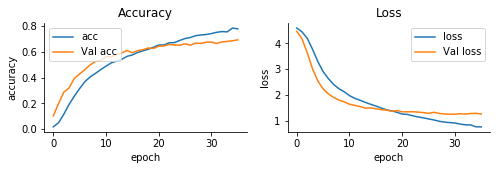

In [32]:
plot_training_curves(history.history);

In [33]:
score = model_lstm.evaluate(X_lstm_test, Y_lstm_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.21525210533
Test accuracy: 0.701641266155


# Saving and loading the lstm model 

In [35]:
# serialize model to JSON
model_lstm_json = model_lstm.to_json()
with open("model_lstm.json", "w") as json_file:
    json_file.write(model_lstm_json)
# serialize weights to HDF5
model_lstm.save_weights("model_lstm.h5")
print("Saved model to disk")

In [38]:
json_file = open('model_lstm.json', 'r')
loaded_model_json = json_file.read()
json_file.close()


In [39]:
from keras.models import model_from_json

In [40]:
loaded_model_lstm = model_from_json(loaded_model_json)
# load weights into new model
loaded_model_lstm.load_weights("model_lstm.h5")
print("Loaded model from disk")

Loaded model from disk


In [41]:
metrics = ['accuracy']
if nb_classes >= 10:
    metrics.append('top_k_categorical_accuracy')
    
optimizer = Adam(lr=1e-5, decay=1e-6)
loaded_model_lstm.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)

In [43]:
loaded_model_lstm_predict = loaded_model_lstm.predict(X_lstm_test)

In [45]:
loaded_score = loaded_model_lstm.evaluate(X_lstm_test, Y_lstm_test, verbose=0)
print('Test loss:', loaded_score[0])
print('Test accuracy:', loaded_score[1])

Test loss: 1.21525210533
Test accuracy: 0.701641266155


# Building MLP MODEL 

In [30]:
model_mlp = Sequential()
model_mlp.add(Flatten(input_shape=input_shape))
model_mlp.add(Dense(512))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(512))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(nb_classes, activation='softmax'))

In [31]:
metrics = ['accuracy']
if nb_classes >= 10:
    metrics.append('top_k_categorical_accuracy')
    
optimizer = Adam(lr=1e-5, decay=1e-6)
model_mlp.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)

print(model_mlp.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 81920)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               41943552  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 101)               51813     
Total params: 42,258,021
Trainable params: 42,258,021
Non-trainable params: 0
________________________________________________________________

In [32]:
checkpointer_mlp = ModelCheckpoint(
    filepath=os.path.join('data', 'checkpoints', 'mlp' + '-' + data_type + '.{epoch:03d}-{val_loss:.3f}.hdf5'),verbose=1, save_best_only=True)

# Helper: TensorBoard
tb_mlp = TensorBoard(log_dir=os.path.join('data', 'logs', 'mlp'))

# Helper: Stop when we stop learning.
early_stopper_mlp = EarlyStopping(patience=5)

# Helper: Save results.
timestamp_mlp = time.time()
csv_logger_mlp = CSVLogger(os.path.join('data', 'logs', 'mlp' + '-' + 'training-' + str(timestamp_mlp) + '.log'))

In [36]:
mlphistory = model_mlp.fit( X_lstm,Y_lstm, 
    batch_size=32,
    validation_data=(X_lstm_val,Y_lstm_val ),
    verbose=1,
    callbacks=[tb_mlp, early_stopper_mlp, csv_logger_mlp], epochs=100)

Train on 8596 samples, validate on 1712 samples
Epoch 1/100
3424/8596 [==========>...................] - ETA: 2:38 - loss: 6.1174 - acc: 0.0000e+00 - top_k_categorical_accuracy: 0.0000e+ - ETA: 1:31 - loss: 6.1304 - acc: 0.0000e+00 - top_k_categorical_accuracy: 0.0156   - ETA: 1:09 - loss: 6.0694 - acc: 0.0000e+00 - top_k_categorical_accuracy: 0.04 - ETA: 58s - loss: 6.0339 - acc: 0.0078 - top_k_categorical_accuracy: 0.0547     - ETA: 52s - loss: 5.9745 - acc: 0.0063 - top_k_categorical_accuracy: 0.068 - ETA: 47s - loss: 6.0664 - acc: 0.0052 - top_k_categorical_accuracy: 0.057 - ETA: 43s - loss: 6.0220 - acc: 0.0045 - top_k_categorical_accuracy: 0.062 - ETA: 41s - loss: 6.0411 - acc: 0.0078 - top_k_categorical_accuracy: 0.058 - ETA: 39s - loss: 6.0312 - acc: 0.0104 - top_k_categorical_accuracy: 0.062 - ETA: 37s - loss: 6.0282 - acc: 0.0094 - top_k_categorical_accuracy: 0.065 - ETA: 36s - loss: 6.0482 - acc: 0.0085 - top_k_categorical_accuracy: 0.065 - ETA: 35s - loss: 6.0725 - acc: 0.0

3456/8596 [===========>..................] - ETA: 24s - loss: 2.6700 - acc: 0.4688 - top_k_categorical_accuracy: 0.593 - ETA: 24s - loss: 2.6720 - acc: 0.4375 - top_k_categorical_accuracy: 0.609 - ETA: 24s - loss: 2.6378 - acc: 0.4375 - top_k_categorical_accuracy: 0.614 - ETA: 24s - loss: 2.6843 - acc: 0.4219 - top_k_categorical_accuracy: 0.601 - ETA: 24s - loss: 2.7014 - acc: 0.4250 - top_k_categorical_accuracy: 0.612 - ETA: 24s - loss: 2.6784 - acc: 0.4219 - top_k_categorical_accuracy: 0.614 - ETA: 24s - loss: 2.6536 - acc: 0.4062 - top_k_categorical_accuracy: 0.611 - ETA: 24s - loss: 2.6056 - acc: 0.4141 - top_k_categorical_accuracy: 0.625 - ETA: 24s - loss: 2.5705 - acc: 0.4167 - top_k_categorical_accuracy: 0.628 - ETA: 24s - loss: 2.5338 - acc: 0.4188 - top_k_categorical_accuracy: 0.643 - ETA: 24s - loss: 2.5782 - acc: 0.4148 - top_k_categorical_accuracy: 0.633 - ETA: 24s - loss: 2.5540 - acc: 0.4271 - top_k_categorical_accuracy: 0.640 - ETA: 24s - loss: 2.5538 - acc: 0.4207 - top

8596/8596 [==============================] - ETA: 4s - loss: 2.0989 - acc: 0.4875 - top_k_categorical_accuracy: 0.74 - ETA: 4s - loss: 2.0992 - acc: 0.4876 - top_k_categorical_accuracy: 0.74 - ETA: 4s - loss: 2.0980 - acc: 0.4879 - top_k_categorical_accuracy: 0.74 - ETA: 4s - loss: 2.0984 - acc: 0.4874 - top_k_categorical_accuracy: 0.74 - ETA: 4s - loss: 2.0973 - acc: 0.4875 - top_k_categorical_accuracy: 0.74 - ETA: 4s - loss: 2.0959 - acc: 0.4874 - top_k_categorical_accuracy: 0.74 - ETA: 4s - loss: 2.0932 - acc: 0.4879 - top_k_categorical_accuracy: 0.74 - ETA: 4s - loss: 2.0905 - acc: 0.4878 - top_k_categorical_accuracy: 0.74 - ETA: 4s - loss: 2.0884 - acc: 0.4878 - top_k_categorical_accuracy: 0.74 - ETA: 3s - loss: 2.0856 - acc: 0.4883 - top_k_categorical_accuracy: 0.74 - ETA: 3s - loss: 2.0866 - acc: 0.4885 - top_k_categorical_accuracy: 0.74 - ETA: 3s - loss: 2.0845 - acc: 0.4892 - top_k_categorical_accuracy: 0.74 - ETA: 3s - loss: 2.0805 - acc: 0.4904 - top_k_categorical_accuracy: 

3456/8596 [===========>..................] - ETA: 24s - loss: 1.5906 - acc: 0.6875 - top_k_categorical_accuracy: 0.843 - ETA: 24s - loss: 1.3526 - acc: 0.7031 - top_k_categorical_accuracy: 0.906 - ETA: 24s - loss: 1.4610 - acc: 0.6771 - top_k_categorical_accuracy: 0.864 - ETA: 24s - loss: 1.3995 - acc: 0.6875 - top_k_categorical_accuracy: 0.875 - ETA: 24s - loss: 1.3908 - acc: 0.6875 - top_k_categorical_accuracy: 0.868 - ETA: 24s - loss: 1.3660 - acc: 0.6979 - top_k_categorical_accuracy: 0.875 - ETA: 24s - loss: 1.3429 - acc: 0.7009 - top_k_categorical_accuracy: 0.879 - ETA: 24s - loss: 1.3843 - acc: 0.6992 - top_k_categorical_accuracy: 0.871 - ETA: 24s - loss: 1.3676 - acc: 0.6979 - top_k_categorical_accuracy: 0.868 - ETA: 24s - loss: 1.3170 - acc: 0.7000 - top_k_categorical_accuracy: 0.878 - ETA: 24s - loss: 1.3280 - acc: 0.6875 - top_k_categorical_accuracy: 0.877 - ETA: 24s - loss: 1.3213 - acc: 0.6849 - top_k_categorical_accuracy: 0.882 - ETA: 24s - loss: 1.3281 - acc: 0.6851 - top

8596/8596 [==============================] - ETA: 4s - loss: 1.1703 - acc: 0.6881 - top_k_categorical_accuracy: 0.90 - ETA: 4s - loss: 1.1711 - acc: 0.6881 - top_k_categorical_accuracy: 0.90 - ETA: 4s - loss: 1.1688 - acc: 0.6888 - top_k_categorical_accuracy: 0.90 - ETA: 4s - loss: 1.1686 - acc: 0.6886 - top_k_categorical_accuracy: 0.90 - ETA: 4s - loss: 1.1672 - acc: 0.6889 - top_k_categorical_accuracy: 0.90 - ETA: 4s - loss: 1.1655 - acc: 0.6893 - top_k_categorical_accuracy: 0.90 - ETA: 4s - loss: 1.1651 - acc: 0.6892 - top_k_categorical_accuracy: 0.90 - ETA: 4s - loss: 1.1678 - acc: 0.6886 - top_k_categorical_accuracy: 0.90 - ETA: 4s - loss: 1.1670 - acc: 0.6887 - top_k_categorical_accuracy: 0.90 - ETA: 3s - loss: 1.1650 - acc: 0.6894 - top_k_categorical_accuracy: 0.90 - ETA: 3s - loss: 1.1637 - acc: 0.6900 - top_k_categorical_accuracy: 0.90 - ETA: 3s - loss: 1.1632 - acc: 0.6901 - top_k_categorical_accuracy: 0.90 - ETA: 3s - loss: 1.1633 - acc: 0.6902 - top_k_categorical_accuracy: 

3456/8596 [===========>..................] - ETA: 24s - loss: 0.7193 - acc: 0.8438 - top_k_categorical_accuracy: 0.937 - ETA: 24s - loss: 0.8691 - acc: 0.7500 - top_k_categorical_accuracy: 0.968 - ETA: 24s - loss: 0.8850 - acc: 0.7396 - top_k_categorical_accuracy: 0.947 - ETA: 24s - loss: 0.8850 - acc: 0.7578 - top_k_categorical_accuracy: 0.945 - ETA: 24s - loss: 0.8145 - acc: 0.7875 - top_k_categorical_accuracy: 0.943 - ETA: 24s - loss: 0.7974 - acc: 0.7865 - top_k_categorical_accuracy: 0.947 - ETA: 24s - loss: 0.7964 - acc: 0.7946 - top_k_categorical_accuracy: 0.946 - ETA: 24s - loss: 0.7963 - acc: 0.7852 - top_k_categorical_accuracy: 0.949 - ETA: 24s - loss: 0.8313 - acc: 0.7708 - top_k_categorical_accuracy: 0.947 - ETA: 24s - loss: 0.8126 - acc: 0.7812 - top_k_categorical_accuracy: 0.950 - ETA: 24s - loss: 0.8338 - acc: 0.7784 - top_k_categorical_accuracy: 0.946 - ETA: 24s - loss: 0.8300 - acc: 0.7839 - top_k_categorical_accuracy: 0.945 - ETA: 24s - loss: 0.8255 - acc: 0.7837 - top

8596/8596 [==============================] - ETA: 4s - loss: 0.7845 - acc: 0.7834 - top_k_categorical_accuracy: 0.94 - ETA: 4s - loss: 0.7846 - acc: 0.7837 - top_k_categorical_accuracy: 0.94 - ETA: 4s - loss: 0.7845 - acc: 0.7831 - top_k_categorical_accuracy: 0.94 - ETA: 4s - loss: 0.7861 - acc: 0.7825 - top_k_categorical_accuracy: 0.94 - ETA: 4s - loss: 0.7852 - acc: 0.7829 - top_k_categorical_accuracy: 0.94 - ETA: 4s - loss: 0.7852 - acc: 0.7828 - top_k_categorical_accuracy: 0.94 - ETA: 4s - loss: 0.7859 - acc: 0.7828 - top_k_categorical_accuracy: 0.94 - ETA: 4s - loss: 0.7882 - acc: 0.7818 - top_k_categorical_accuracy: 0.94 - ETA: 4s - loss: 0.7886 - acc: 0.7818 - top_k_categorical_accuracy: 0.94 - ETA: 3s - loss: 0.7904 - acc: 0.7814 - top_k_categorical_accuracy: 0.94 - ETA: 3s - loss: 0.7892 - acc: 0.7818 - top_k_categorical_accuracy: 0.94 - ETA: 3s - loss: 0.7908 - acc: 0.7808 - top_k_categorical_accuracy: 0.94 - ETA: 3s - loss: 0.7904 - acc: 0.7807 - top_k_categorical_accuracy: 

3456/8596 [===========>..................] - ETA: 24s - loss: 0.3725 - acc: 0.9375 - top_k_categorical_accuracy: 0.968 - ETA: 24s - loss: 0.3734 - acc: 0.9062 - top_k_categorical_accuracy: 0.984 - ETA: 24s - loss: 0.3696 - acc: 0.9062 - top_k_categorical_accuracy: 0.989 - ETA: 24s - loss: 0.3290 - acc: 0.9219 - top_k_categorical_accuracy: 0.992 - ETA: 24s - loss: 0.3673 - acc: 0.9062 - top_k_categorical_accuracy: 0.993 - ETA: 24s - loss: 0.3793 - acc: 0.9062 - top_k_categorical_accuracy: 0.994 - ETA: 24s - loss: 0.3786 - acc: 0.9018 - top_k_categorical_accuracy: 0.995 - ETA: 24s - loss: 0.4348 - acc: 0.8828 - top_k_categorical_accuracy: 0.988 - ETA: 24s - loss: 0.4549 - acc: 0.8819 - top_k_categorical_accuracy: 0.986 - ETA: 24s - loss: 0.4833 - acc: 0.8812 - top_k_categorical_accuracy: 0.981 - ETA: 24s - loss: 0.5116 - acc: 0.8750 - top_k_categorical_accuracy: 0.980 - ETA: 24s - loss: 0.5078 - acc: 0.8750 - top_k_categorical_accuracy: 0.981 - ETA: 24s - loss: 0.4941 - acc: 0.8798 - top

8596/8596 [==============================] - ETA: 4s - loss: 0.5727 - acc: 0.8425 - top_k_categorical_accuracy: 0.96 - ETA: 4s - loss: 0.5719 - acc: 0.8428 - top_k_categorical_accuracy: 0.96 - ETA: 4s - loss: 0.5707 - acc: 0.8430 - top_k_categorical_accuracy: 0.96 - ETA: 4s - loss: 0.5707 - acc: 0.8430 - top_k_categorical_accuracy: 0.96 - ETA: 4s - loss: 0.5701 - acc: 0.8430 - top_k_categorical_accuracy: 0.96 - ETA: 4s - loss: 0.5694 - acc: 0.8432 - top_k_categorical_accuracy: 0.96 - ETA: 4s - loss: 0.5697 - acc: 0.8431 - top_k_categorical_accuracy: 0.96 - ETA: 4s - loss: 0.5689 - acc: 0.8432 - top_k_categorical_accuracy: 0.97 - ETA: 4s - loss: 0.5676 - acc: 0.8436 - top_k_categorical_accuracy: 0.97 - ETA: 3s - loss: 0.5686 - acc: 0.8432 - top_k_categorical_accuracy: 0.97 - ETA: 3s - loss: 0.5688 - acc: 0.8433 - top_k_categorical_accuracy: 0.96 - ETA: 3s - loss: 0.5678 - acc: 0.8438 - top_k_categorical_accuracy: 0.96 - ETA: 3s - loss: 0.5680 - acc: 0.8438 - top_k_categorical_accuracy: 

3456/8596 [===========>..................] - ETA: 24s - loss: 0.3613 - acc: 0.9062 - top_k_categorical_accuracy: 1.000 - ETA: 25s - loss: 0.4537 - acc: 0.8750 - top_k_categorical_accuracy: 1.000 - ETA: 25s - loss: 0.5230 - acc: 0.8854 - top_k_categorical_accuracy: 0.979 - ETA: 25s - loss: 0.4881 - acc: 0.8828 - top_k_categorical_accuracy: 0.984 - ETA: 25s - loss: 0.4840 - acc: 0.8812 - top_k_categorical_accuracy: 0.981 - ETA: 24s - loss: 0.4980 - acc: 0.8698 - top_k_categorical_accuracy: 0.979 - ETA: 25s - loss: 0.5107 - acc: 0.8616 - top_k_categorical_accuracy: 0.973 - ETA: 24s - loss: 0.4799 - acc: 0.8711 - top_k_categorical_accuracy: 0.976 - ETA: 24s - loss: 0.4612 - acc: 0.8750 - top_k_categorical_accuracy: 0.979 - ETA: 24s - loss: 0.4511 - acc: 0.8812 - top_k_categorical_accuracy: 0.975 - ETA: 24s - loss: 0.4505 - acc: 0.8807 - top_k_categorical_accuracy: 0.977 - ETA: 24s - loss: 0.4368 - acc: 0.8828 - top_k_categorical_accuracy: 0.976 - ETA: 24s - loss: 0.4332 - acc: 0.8822 - top

8596/8596 [==============================] - ETA: 4s - loss: 0.4108 - acc: 0.8847 - top_k_categorical_accuracy: 0.98 - ETA: 4s - loss: 0.4114 - acc: 0.8846 - top_k_categorical_accuracy: 0.98 - ETA: 4s - loss: 0.4121 - acc: 0.8845 - top_k_categorical_accuracy: 0.98 - ETA: 4s - loss: 0.4130 - acc: 0.8838 - top_k_categorical_accuracy: 0.98 - ETA: 4s - loss: 0.4136 - acc: 0.8836 - top_k_categorical_accuracy: 0.98 - ETA: 4s - loss: 0.4123 - acc: 0.8841 - top_k_categorical_accuracy: 0.98 - ETA: 4s - loss: 0.4130 - acc: 0.8841 - top_k_categorical_accuracy: 0.98 - ETA: 4s - loss: 0.4129 - acc: 0.8836 - top_k_categorical_accuracy: 0.98 - ETA: 4s - loss: 0.4120 - acc: 0.8837 - top_k_categorical_accuracy: 0.98 - ETA: 3s - loss: 0.4118 - acc: 0.8837 - top_k_categorical_accuracy: 0.98 - ETA: 3s - loss: 0.4107 - acc: 0.8840 - top_k_categorical_accuracy: 0.98 - ETA: 3s - loss: 0.4100 - acc: 0.8844 - top_k_categorical_accuracy: 0.98 - ETA: 3s - loss: 0.4091 - acc: 0.8849 - top_k_categorical_accuracy: 

3456/8596 [===========>..................] - ETA: 24s - loss: 0.5083 - acc: 0.8125 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.3621 - acc: 0.8594 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.3917 - acc: 0.8646 - top_k_categorical_accuracy: 0.989 - ETA: 24s - loss: 0.3601 - acc: 0.8750 - top_k_categorical_accuracy: 0.992 - ETA: 24s - loss: 0.3985 - acc: 0.8625 - top_k_categorical_accuracy: 0.987 - ETA: 24s - loss: 0.3998 - acc: 0.8698 - top_k_categorical_accuracy: 0.984 - ETA: 24s - loss: 0.4182 - acc: 0.8616 - top_k_categorical_accuracy: 0.977 - ETA: 24s - loss: 0.3952 - acc: 0.8672 - top_k_categorical_accuracy: 0.980 - ETA: 24s - loss: 0.4157 - acc: 0.8646 - top_k_categorical_accuracy: 0.975 - ETA: 24s - loss: 0.4181 - acc: 0.8719 - top_k_categorical_accuracy: 0.971 - ETA: 24s - loss: 0.3972 - acc: 0.8807 - top_k_categorical_accuracy: 0.974 - ETA: 24s - loss: 0.4014 - acc: 0.8828 - top_k_categorical_accuracy: 0.974 - ETA: 24s - loss: 0.3763 - acc: 0.8918 - top

8596/8596 [==============================] - ETA: 4s - loss: 0.3378 - acc: 0.9015 - top_k_categorical_accuracy: 0.98 - ETA: 4s - loss: 0.3386 - acc: 0.9013 - top_k_categorical_accuracy: 0.98 - ETA: 4s - loss: 0.3380 - acc: 0.9016 - top_k_categorical_accuracy: 0.98 - ETA: 4s - loss: 0.3380 - acc: 0.9016 - top_k_categorical_accuracy: 0.98 - ETA: 4s - loss: 0.3379 - acc: 0.9017 - top_k_categorical_accuracy: 0.98 - ETA: 4s - loss: 0.3371 - acc: 0.9019 - top_k_categorical_accuracy: 0.98 - ETA: 4s - loss: 0.3366 - acc: 0.9019 - top_k_categorical_accuracy: 0.98 - ETA: 4s - loss: 0.3359 - acc: 0.9024 - top_k_categorical_accuracy: 0.98 - ETA: 4s - loss: 0.3361 - acc: 0.9022 - top_k_categorical_accuracy: 0.98 - ETA: 3s - loss: 0.3366 - acc: 0.9021 - top_k_categorical_accuracy: 0.98 - ETA: 3s - loss: 0.3358 - acc: 0.9024 - top_k_categorical_accuracy: 0.98 - ETA: 3s - loss: 0.3367 - acc: 0.9022 - top_k_categorical_accuracy: 0.98 - ETA: 3s - loss: 0.3370 - acc: 0.9019 - top_k_categorical_accuracy: 

3456/8596 [===========>..................] - ETA: 24s - loss: 0.1768 - acc: 0.9688 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.2797 - acc: 0.9375 - top_k_categorical_accuracy: 0.984 - ETA: 24s - loss: 0.2306 - acc: 0.9479 - top_k_categorical_accuracy: 0.979 - ETA: 24s - loss: 0.2764 - acc: 0.9297 - top_k_categorical_accuracy: 0.976 - ETA: 24s - loss: 0.3239 - acc: 0.9250 - top_k_categorical_accuracy: 0.968 - ETA: 24s - loss: 0.3102 - acc: 0.9271 - top_k_categorical_accuracy: 0.974 - ETA: 24s - loss: 0.3029 - acc: 0.9241 - top_k_categorical_accuracy: 0.977 - ETA: 24s - loss: 0.3123 - acc: 0.9219 - top_k_categorical_accuracy: 0.976 - ETA: 24s - loss: 0.2998 - acc: 0.9236 - top_k_categorical_accuracy: 0.979 - ETA: 24s - loss: 0.2973 - acc: 0.9250 - top_k_categorical_accuracy: 0.978 - ETA: 24s - loss: 0.2879 - acc: 0.9290 - top_k_categorical_accuracy: 0.980 - ETA: 24s - loss: 0.2857 - acc: 0.9297 - top_k_categorical_accuracy: 0.981 - ETA: 24s - loss: 0.2917 - acc: 0.9279 - top

8596/8596 [==============================] - ETA: 4s - loss: 0.2447 - acc: 0.9310 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2444 - acc: 0.9311 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2448 - acc: 0.9310 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2451 - acc: 0.9307 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2447 - acc: 0.9307 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2457 - acc: 0.9305 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2459 - acc: 0.9304 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2453 - acc: 0.9307 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2452 - acc: 0.9307 - top_k_categorical_accuracy: 0.99 - ETA: 3s - loss: 0.2451 - acc: 0.9306 - top_k_categorical_accuracy: 0.99 - ETA: 3s - loss: 0.2447 - acc: 0.9306 - top_k_categorical_accuracy: 0.99 - ETA: 3s - loss: 0.2448 - acc: 0.9304 - top_k_categorical_accuracy: 0.99 - ETA: 3s - loss: 0.2459 - acc: 0.9303 - top_k_categorical_accuracy: 

3456/8596 [===========>..................] - ETA: 24s - loss: 0.1476 - acc: 0.9688 - top_k_categorical_accuracy: 1.000 - ETA: 25s - loss: 0.1903 - acc: 0.9531 - top_k_categorical_accuracy: 1.000 - ETA: 25s - loss: 0.1742 - acc: 0.9479 - top_k_categorical_accuracy: 1.000 - ETA: 25s - loss: 0.2106 - acc: 0.9375 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.2596 - acc: 0.9250 - top_k_categorical_accuracy: 0.993 - ETA: 24s - loss: 0.2374 - acc: 0.9323 - top_k_categorical_accuracy: 0.994 - ETA: 24s - loss: 0.2353 - acc: 0.9330 - top_k_categorical_accuracy: 0.995 - ETA: 24s - loss: 0.2297 - acc: 0.9336 - top_k_categorical_accuracy: 0.996 - ETA: 24s - loss: 0.2484 - acc: 0.9306 - top_k_categorical_accuracy: 0.993 - ETA: 24s - loss: 0.2592 - acc: 0.9187 - top_k_categorical_accuracy: 0.993 - ETA: 24s - loss: 0.2652 - acc: 0.9148 - top_k_categorical_accuracy: 0.991 - ETA: 24s - loss: 0.2489 - acc: 0.9193 - top_k_categorical_accuracy: 0.992 - ETA: 24s - loss: 0.2660 - acc: 0.9087 - top

8596/8596 [==============================] - ETA: 4s - loss: 0.2088 - acc: 0.9397 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2087 - acc: 0.9398 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2102 - acc: 0.9393 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2105 - acc: 0.9392 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2103 - acc: 0.9392 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2101 - acc: 0.9393 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2096 - acc: 0.9395 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2097 - acc: 0.9393 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2095 - acc: 0.9394 - top_k_categorical_accuracy: 0.99 - ETA: 3s - loss: 0.2090 - acc: 0.9397 - top_k_categorical_accuracy: 0.99 - ETA: 3s - loss: 0.2098 - acc: 0.9393 - top_k_categorical_accuracy: 0.99 - ETA: 3s - loss: 0.2109 - acc: 0.9391 - top_k_categorical_accuracy: 0.99 - ETA: 3s - loss: 0.2107 - acc: 0.9391 - top_k_categorical_accuracy: 

3456/8596 [===========>..................] - ETA: 24s - loss: 0.4887 - acc: 0.8750 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.3181 - acc: 0.9219 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.2422 - acc: 0.9375 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.2146 - acc: 0.9531 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.1954 - acc: 0.9500 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.1742 - acc: 0.9583 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.1633 - acc: 0.9598 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.2018 - acc: 0.9492 - top_k_categorical_accuracy: 0.996 - ETA: 24s - loss: 0.2022 - acc: 0.9514 - top_k_categorical_accuracy: 0.996 - ETA: 24s - loss: 0.1988 - acc: 0.9500 - top_k_categorical_accuracy: 0.996 - ETA: 24s - loss: 0.2115 - acc: 0.9403 - top_k_categorical_accuracy: 0.997 - ETA: 24s - loss: 0.2018 - acc: 0.9427 - top_k_categorical_accuracy: 0.997 - ETA: 24s - loss: 0.1916 - acc: 0.9471 - top

8596/8596 [==============================] - ETA: 4s - loss: 0.2060 - acc: 0.9431 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2069 - acc: 0.9425 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2068 - acc: 0.9425 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2079 - acc: 0.9423 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2086 - acc: 0.9420 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2082 - acc: 0.9420 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2078 - acc: 0.9422 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2072 - acc: 0.9425 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.2074 - acc: 0.9426 - top_k_categorical_accuracy: 0.99 - ETA: 3s - loss: 0.2069 - acc: 0.9426 - top_k_categorical_accuracy: 0.99 - ETA: 3s - loss: 0.2074 - acc: 0.9423 - top_k_categorical_accuracy: 0.99 - ETA: 3s - loss: 0.2077 - acc: 0.9421 - top_k_categorical_accuracy: 0.99 - ETA: 3s - loss: 0.2080 - acc: 0.9421 - top_k_categorical_accuracy: 

3456/8596 [===========>..................] - ETA: 24s - loss: 0.1298 - acc: 0.9688 - top_k_categorical_accuracy: 1.000 - ETA: 25s - loss: 0.0990 - acc: 0.9844 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.0955 - acc: 0.9792 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.1068 - acc: 0.9766 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.1142 - acc: 0.9688 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.1135 - acc: 0.9688 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.1343 - acc: 0.9598 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.1231 - acc: 0.9648 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.1160 - acc: 0.9653 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.1135 - acc: 0.9656 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.1151 - acc: 0.9659 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.1225 - acc: 0.9609 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.1380 - acc: 0.9567 - top

8596/8596 [==============================] - ETA: 4s - loss: 0.1686 - acc: 0.9531 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.1680 - acc: 0.9533 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.1677 - acc: 0.9534 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.1679 - acc: 0.9532 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.1683 - acc: 0.9531 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.1682 - acc: 0.9532 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.1685 - acc: 0.9531 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.1688 - acc: 0.9532 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.1687 - acc: 0.9531 - top_k_categorical_accuracy: 0.99 - ETA: 3s - loss: 0.1688 - acc: 0.9531 - top_k_categorical_accuracy: 0.99 - ETA: 3s - loss: 0.1686 - acc: 0.9530 - top_k_categorical_accuracy: 0.99 - ETA: 3s - loss: 0.1681 - acc: 0.9531 - top_k_categorical_accuracy: 0.99 - ETA: 3s - loss: 0.1682 - acc: 0.9530 - top_k_categorical_accuracy: 

3456/8596 [===========>..................] - ETA: 26s - loss: 0.1725 - acc: 0.9062 - top_k_categorical_accuracy: 1.000 - ETA: 25s - loss: 0.1931 - acc: 0.9219 - top_k_categorical_accuracy: 1.000 - ETA: 25s - loss: 0.1647 - acc: 0.9375 - top_k_categorical_accuracy: 1.000 - ETA: 25s - loss: 0.1567 - acc: 0.9531 - top_k_categorical_accuracy: 1.000 - ETA: 25s - loss: 0.1846 - acc: 0.9375 - top_k_categorical_accuracy: 1.000 - ETA: 25s - loss: 0.1719 - acc: 0.9375 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.1611 - acc: 0.9420 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.1558 - acc: 0.9453 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.1576 - acc: 0.9444 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.1588 - acc: 0.9469 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.1520 - acc: 0.9517 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.1559 - acc: 0.9505 - top_k_categorical_accuracy: 1.000 - ETA: 24s - loss: 0.1580 - acc: 0.9495 - top

8596/8596 [==============================] - ETA: 4s - loss: 0.1407 - acc: 0.9580 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.1402 - acc: 0.9582 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.1407 - acc: 0.9578 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.1407 - acc: 0.9579 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.1412 - acc: 0.9576 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.1408 - acc: 0.9578 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.1412 - acc: 0.9577 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.1410 - acc: 0.9579 - top_k_categorical_accuracy: 0.99 - ETA: 4s - loss: 0.1407 - acc: 0.9580 - top_k_categorical_accuracy: 0.99 - ETA: 3s - loss: 0.1405 - acc: 0.9581 - top_k_categorical_accuracy: 0.99 - ETA: 3s - loss: 0.1403 - acc: 0.9583 - top_k_categorical_accuracy: 0.99 - ETA: 3s - loss: 0.1407 - acc: 0.9581 - top_k_categorical_accuracy: 0.99 - ETA: 3s - loss: 0.1403 - acc: 0.9583 - top_k_categorical_accuracy: 

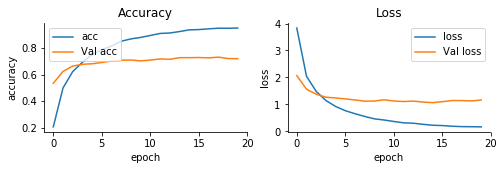

In [93]:
plot_training_curves(mlphistory.history);

In [41]:
model_mlp_predict = model_mlp.predict(X_lstm_test)

In [42]:
score_mlp = model_mlp.evaluate(X_lstm_test, Y_lstm_test, verbose=0)
print('Test loss:', score_mlp[0])
print('Test accuracy:', score_mlp[1])

Test loss: 1.146074497
Test accuracy: 0.72919109034


In [45]:
num_predictions = 20
for predict_index, predicted_y in enumerate(model_mlp_predict):
    actual_label = classes[np.argmax(Y_lstm_test[predict_index])]
    predicted_label = classes[np.argmax(predicted_y)]
    print('Actual Label = %s vs. Predicted Label = %s' % (actual_label,
                                                          predicted_label))
    if predict_index == num_predictions:
        break

Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyLipstick
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyEyeMakeup
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyEyeMakeup
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyLipstick
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyLipstick
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyLipstick
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyEyeMakeup
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyEyeMakeup
Actual Label = ApplyEyeMakeup vs. Predicted Label = HulaHoop
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyEyeMakeup
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyEyeMakeup
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyLipstick
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyEyeMakeup
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyEyeMakeup
Actual Label = ApplyEyeMakeup vs. Predicted Label = ApplyEyeMakeup
Actual

In [47]:
model_mlp_predict[1].argsort()[-3:][::-1]

array([ 0,  1, 77], dtype=int64)

# save and load the mlp model 

In [ ]:
# serialize model to JSON
model_mlp_json = model_mlp.to_json()
with open("model_mlp.json", "w") as json_file:
    json_file.write(model_mlp_json)
# serialize weights to HDF5
model_mlp.save_weights("model_mlp.h5")
print("Saved model to disk")

In [ ]:
from keras.models import model_from_json

json_file = open('model_mlp.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model_mlp = model_from_json(loaded_model_json)
# load weights into new model
loaded_model_mlp.load_weights("model_mlp.h5")
print("Loaded model from disk")

In [12]:
# saving all the class in csv file 
with open ("classes.csv",'a+') as outputfile1:
        for i in classes:
            outputfile1.write( i +"\n")